# Import

In [21]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
import numpy as np 
from sklearn import svm

# Variables

In [2]:
# Nombre de cluster souhaité
k_count = 10

# Data

In [3]:
# On recupere les images
lfw = fetch_lfw_people()
type(lfw)

sklearn.utils.Bunch

In [4]:
# On regarder les differentes clés possible
lfw.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [5]:
# Affichage d'informations sur les datas
print(lfw.data.shape)
print(lfw.images.shape)
print(lfw.target.shape)
print(type(lfw.target[0]))
print(lfw.target_names.shape)
print(type(lfw.target_names[0]))

(13233, 2914)
(13233, 62, 47)
(13233,)
<class 'numpy.int64'>
(5749,)
<class 'numpy.str_'>


## Images utiliser dans le TP

In [6]:
# Filtrage des datas
# On veut les personnes avec au moins 100 images
lfw = fetch_lfw_people(min_faces_per_person=100,resize=1)

# Affichage des datas aprés filtrage
print(lfw.data.shape)
print(lfw.images.shape)
print(lfw.target.shape)
print(type(lfw.target[0]))
print(lfw.target_names.shape)
print(type(lfw.target_names[0]))

# On récupere le noms des personnes
classesNames = []
for name in lfw.target_names:
    classesNames.append(name)
print(classesNames)

(1140, 11750)
(1140, 125, 94)
(1140,)
<class 'numpy.int64'>
(5,)
<class 'numpy.str_'>
['Colin Powell', 'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder', 'Tony Blair']


## Organisation des images

In [7]:
# On veut 75% d'images d'entrainements
X = lfw.images
y = lfw.target
Xtrain, Xtest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state=33)
#print(len(Xtrain))
#print(len(yTrain))


# Description des images

In [8]:
# ---------------------------------------------
# On veut récuperer les SIFTs des images
# ---------------------------------------------

# variable sift
sift = cv2.SIFT_create()

# img recupere les images d'entrainements
img = Xtrain

# Recupere les informations des images
kp = list()
des = list()

# Recupere les descripteurs SIFTs des images (myDes) + le nombres de descripteurs sift par image (myDesLen)
myDes = []
myDesLen = []

# Pour le nombre d'image
for i in range(len(img)):
    # On normalise l'image
    imgTmp = cv2.normalize(img[i], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # Recupere les informations de l'image
    kpTmp, desTmp = sift.detectAndCompute(imgTmp,None)
    # Stock les informations
    kp.append(kpTmp)
    des.append(desTmp)
    # Pour chaque descripteur sift de l'image
    for data in desTmp:
        # Stock le descripteur sift
        myDes.append(data)
    # Stock le nombre de descripteur sift de l'image analysé
    myDesLen.append(len(desTmp))
    #print(len(desTmp))    

# Partitionnement par KMeans

In [9]:
# ---------------------------------------------
# On veut construire les barycentre
# ---------------------------------------------

kmeans1 = KMeans(n_clusters=k_count, init='k-means++')
# J'entraine le model avec les descripteurs sifts
kmeans1.fit(myDes)
print(kmeans1)

KMeans(n_clusters=10)


# calculer les bows

In [14]:
# ---------------------------------------------
# On veut faire une prédiction avec les données d'entrainements
# ---------------------------------------------

# On recupere les données d'entrainements
classes = yTrain

# Variables
bofs = np.empty(shape=(len(classes),k_count)) # tableau des numéros de cluster pour les 
# descripteurs sifts des images
i = 0 # Index de bofs
j = 0 # Index de lecture du nombre de sift pour l'image analysée
k = 1 # Pour affichage du numéros de prediction

# Pour le nombre de descripteurs sifts d'une image / Pour chaque image
for ds in myDesLen:
    # Tableau temporaire qui recupere les numéros de cluster
    tmpBof = np.array([0]*k_count)
    # Recupere les sifts de l'image
    sifts = myDes[j:j+ds]
    j += ds
    #print("Predict ",k," ...")
    k=k+1
    # Pour chaque sift de l'image
    for sift in sifts:
        # Predit le cluster
        clusterID = kmeans1.predict([sift])
        # Stock le cluster
        tmpBof[clusterID[0]] += 1
    # Stock les clusters de l'image
    bofs[i] = tmpBof
    i+= 1
    

855


# Logistic Regression

In [11]:
# ---------------------------------------------
# Résolution par regression linéaire
# ---------------------------------------------

# Fabrication du model
logic_reg_2 = LogisticRegression()
scaler_2 = preprocessing.StandardScaler().fit(bofs)
xTrain2 = scaler_2.transform(bofs)

# Données d'entrainement
yTrain2 = []
for clNumber in yTrain:
    yTrain2 += [clNumber]

# Entrainement du model
logic_reg_2.fit(xTrain2, yTrain2)

LogisticRegression()

# Statistique sur les données d'entrainements

In [12]:
# ---------------------------------------------
# Est ce que le systeme prédit de façon fiable?
# ---------------------------------------------

# Prediction
ypred2 = logic_reg_2.predict(xTrain2)

# Affichage du résutat
print("train F1 score = ", f1_score(yTrain2, ypred2, average = 'micro'))
print("train accuracy score = ", accuracy_score(yTrain2, ypred2))

train F1 score =  0.560233918128655
train accuracy score =  0.560233918128655


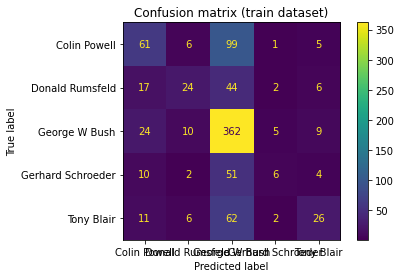

In [13]:
# ---------------------------------------------
# Matrice de confusion
# ---------------------------------------------

# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(yTrain2, ypred2, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

# Analyse

## Avec 10 clusters 

Les statistiques nous montre que le résultat et un peu mieux que de l'aléatoire: 56%
Néamoins, nous trouvons que le résultat n'est pas suffisament fiable. La matrice de confusion nous montre nous montre tous les faux positifs.

## La suite

Essayer avec d'autres quantités de clusters

KMeans(n_clusters=50)
train F1 score =  0.7204678362573099
train accuracy score =  0.7204678362573099


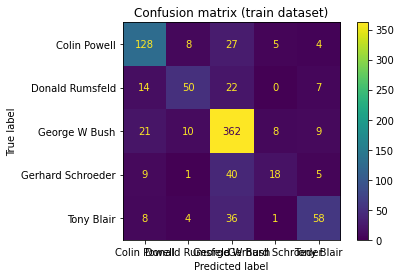

In [52]:
k_count = 50

# ==========================================================================
#                             DESCRIPTEUR SIFT
# ==========================================================================

# ---------------------------------------------
# On veut récuperer les SIFTs des images
# ---------------------------------------------

# variable sift
sift = cv2.SIFT_create()

# img recupere les images d'entrainements
img = Xtrain

# Recupere les informations des images
kp = list()
des = list()

# Recupere les descripteurs SIFTs des images (myDes) + le nombres de descripteurs sift par image (myDesLen)
myDes = []
myDesLen = []

# Pour le nombre d'image
for i in range(len(img)):
    # On normalise l'image
    imgTmp = cv2.normalize(img[i], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # Recupere les informations de l'image
    kpTmp, desTmp = sift.detectAndCompute(imgTmp,None)
    # Stock les informations
    kp.append(kpTmp)
    des.append(desTmp)
    # Pour chaque descripteur sift de l'image
    for data in desTmp:
        # Stock le descripteur sift
        myDes.append(data)
    # Stock le nombre de descripteur sift de l'image analysé
    myDesLen.append(len(desTmp))
    #print(len(desTmp))
    
# ==========================================================================
#                        PARTITIONNEMENT PAR KMEANS
# ==========================================================================

# ---------------------------------------------
# On veut construire les barycentre
# ---------------------------------------------

kmeans1 = KMeans(n_clusters=k_count, init='k-means++')
# J'entraine le model avec les descripteurs sifts
kmeans1.fit(myDes)
print(kmeans1)

# ==========================================================================
#                        CALCUL DES BOWS
# ==========================================================================

# ---------------------------------------------
# On veut faire une prédiction avec les données d'entrainements
# ---------------------------------------------

# On recupere les données d'entrainements
classes = yTrain

# Variables
bofs = np.empty(shape=(len(classes),k_count)) # tableau des numéros de cluster pour les 
# descripteurs sifts des images
i = 0 # Index de bofs
j = 0 # Index de lecture du nombre de sift pour l'image analysée
k = 1 # Pour affichage du numéros de prediction

# Pour le nombre de descripteurs sifts d'une image / Pour chaque image
for ds in myDesLen:
    # Tableau temporaire qui recupere les numéros de cluster
    tmpBof = np.array([0]*k_count)
    # Recupere les sifts de l'image
    sifts = myDes[j:j+ds]
    j += ds
    #print("Predict ",k," ...")
    k=k+1
    # Pour chaque sift de l'image
    for sift in sifts:
        # Predit le cluster
        clusterID = kmeans1.predict([sift])
        # Stock le cluster
        tmpBof[clusterID[0]] += 1
    # Stock les clusters de l'image
    bofs[i] = tmpBof
    i+= 1
    
# ==========================================================================
#                        REGRESSION LINEAIRE
# ==========================================================================

# ---------------------------------------------
# Résolution par regression linéaire
# ---------------------------------------------

# Fabrication du model
logic_reg_2 = LogisticRegression()
scaler_2 = preprocessing.StandardScaler().fit(bofs)
xTrain2 = scaler_2.transform(bofs)

# Données d'entrainement
yTrain2 = []
for clNumber in yTrain:
    yTrain2 += [clNumber]

# Entrainement du model
logic_reg_2.fit(xTrain2, yTrain2)

# ==========================================================================
#                        PREDICTION
# ==========================================================================

# Prediction
ypred2 = logic_reg_2.predict(xTrain2)
# Affichage du résutat
print("train F1 score = ", f1_score(yTrain2, ypred2, average = 'micro'))
print("train accuracy score = ", accuracy_score(yTrain2, ypred2))

# ==========================================================================
#                        MATRICE DE CONFUSION
# ==========================================================================

# ---------------------------------------------
# Matrice de confusion
# ---------------------------------------------

# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(yTrain2, ypred2, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

# Analyse avec differentes valeurs de k_means

| Nombre de Kmeans | Statistique |
|------------------|-------------|
| 20               | 61.75%      |
| 50               | 70%         |
| 100              | 83.7%       |
| 200              | 100%        |


Ici on peut voir qu'avec 200 kmeans, on obtient 100% de reussite. 

# Clasification SVM

## Evaluation de la classification

In [118]:
# variable sift
sift = cv2.SIFT_create()

# img recupere les images d'entrainements
img = Xtest

# Recupere les informations des images
kp = list()
des = list()

# Recupere les descripteurs SIFTs des images (myDes) + le nombres de descripteurs sift par image (myDesLen)
myDes = []
myDesLen = []

# Pour le nombre d'image
for i in range(len(img)):
    # On normalise l'image
    imgTmp = cv2.normalize(img[i], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # Recupere les informations de l'image
    kpTmp, desTmp = sift.detectAndCompute(imgTmp,None)
    # Stock les informations
    kp.append(kpTmp)
    des.append(desTmp)
    # Pour chaque descripteur sift de l'image
    for data in desTmp:
        # Stock le descripteur sift
        myDes.append(data)
    # Stock le nombre de descripteur sift de l'image analysé
    myDesLen.append(len(desTmp))
    #print(len(desTmp))


classes = yTest

bofs_test = np.empty(shape=(len(classes),k_count))

# descripteurs sifts des images
i = 0 # Index de bofs
j = 0 # Index de lecture du nombre de sift pour l'image analysée
k = 1 # Pour affichage du numéros de prediction

# Pour le nombre de descripteurs sifts d'une image / Pour chaque image
for ds in myDesLen:
    # Tableau temporaire qui recupere les numéros de cluster
    tmpBof = np.array([0]*k_count)
    # Recupere les sifts de l'image
    sifts = myDes[j:j+ds]
    j += ds
    #print("Predict ",k," ...")
    k=k+1
    # Pour chaque sift de l'image
    for sift in sifts:
        # Predit le cluster
        clusterID = kmeans1.predict([sift])
        # Stock le cluster
        tmpBof[clusterID[0]] += 1
    # Stock les clusters de l'image
    bofs_test[i] = tmpBof
    i+= 1

## Kernel : linear && Decision_function_shape=ovr

In [119]:
#X = [[0, 0], [1, 1]]
#y = [0,1]

#print(Xtest)

X = bofs_test
y = yTest


# classif = svm.SVC(kernel='linear')
classif = svm.SVC(kernel='linear', decision_function_shape='ovr')
classif.fit(X, y)

#print(Xtest.shape)

ypred2linearovr = classif.predict(X)

#print("prediction class for [2,2]", classif.predict([[2., 2.]])
#print("support vectors: ", classif.support_vectors_)

In [120]:
linearovr = f1_score(y, ypred2linearovr, average = 'micro')
print("train F1 score = ", linearovr)
print("train accuracy score = ", accuracy_score(y, ypred2linearovr))

train F1 score =  0.9859649122807017
train accuracy score =  0.9859649122807017


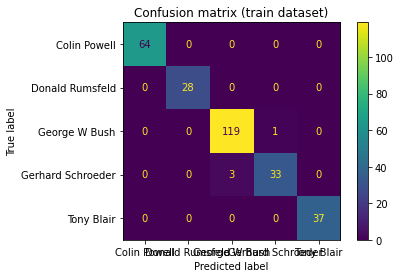

In [121]:
# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(y, ypred2linearovr, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

## Kernel : rbf && Decision_function_shape=ovr

In [122]:
X = bofs_test
y = yTest


# classif = svm.SVC(kernel='linear')
classif = svm.SVC(kernel='rbf', decision_function_shape='ovr')
classif.fit(X, y)

#print(Xtest.shape)

ypred2rbfovr = classif.predict(X)

#print("prediction class for [2,2]", classif.predict([[2., 2.]])
#print("support vectors: ", classif.support_vectors_)

In [123]:
rbfovr = f1_score(y, ypred2rbfovr, average = 'micro')
print("train F1 score = ", rbfovr)
print("train accuracy score = ", accuracy_score(y, ypred2rbfovr))

train F1 score =  0.9052631578947369
train accuracy score =  0.9052631578947369


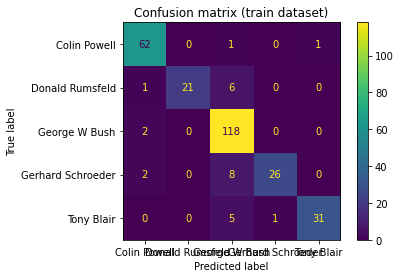

In [124]:
# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(y, ypred2rbfovr, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

## Kernel : poly && Decision_function_shape=ovr

In [125]:
X = bofs_test
y = yTest


# classif = svm.SVC(kernel='linear')
classif = svm.SVC(kernel='poly', decision_function_shape='ovr')
classif.fit(X, y)

#print(Xtest.shape)

ypred2polyovr = classif.predict(X)

#print("prediction class for [2,2]", classif.predict([[2., 2.]])
#print("support vectors: ", classif.support_vectors_)

In [126]:
polyovr = f1_score(y, ypred2polyovr, average = 'micro')
print("train F1 score = ", polyovr)
print("train accuracy score = ", accuracy_score(y, ypred2polyovr))

train F1 score =  0.9789473684210527
train accuracy score =  0.9789473684210527


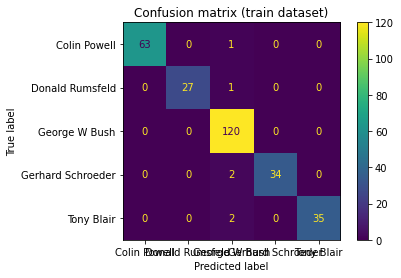

In [127]:
# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(y, ypred2polyovr, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

## Kernel : linear && Decision_function_shape=ovo

In [128]:
X = bofs_test
y = yTest


# classif = svm.SVC(kernel='linear')
classif = svm.SVC(kernel='linear', decision_function_shape='ovo')
classif.fit(X, y)

#print(Xtest.shape)

ypred2linearovo = classif.predict(X)

#print("prediction class for [2,2]", classif.predict([[2., 2.]])
#print("support vectors: ", classif.support_vectors_)

In [129]:
linearovo = f1_score(y, ypred2linearovo, average = 'micro')
print("train F1 score = ", linearovo)
print("train accuracy score = ", accuracy_score(y, ypred2linearovo))

train F1 score =  0.9859649122807017
train accuracy score =  0.9859649122807017


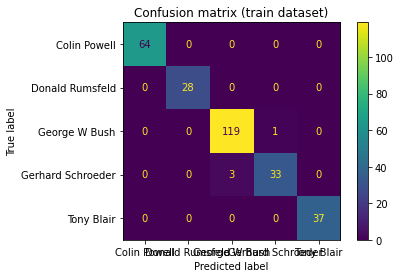

In [130]:
# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(y, ypred2linearovo, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

## Kernel : rbf && Decision_function_shape=ovo

In [131]:
X = bofs_test
y = yTest


# classif = svm.SVC(kernel='linear')
classif = svm.SVC(kernel='rbf', decision_function_shape='ovo')
classif.fit(X, y)

#print(Xtest.shape)

ypred2rbfovo = classif.predict(X)

#print("prediction class for [2,2]", classif.predict([[2., 2.]])
#print("support vectors: ", classif.support_vectors_)

In [132]:
rbfovo = f1_score(y, ypred2rbfovo, average = 'micro')
print("train F1 score = ", f1_score(y, ypred2rbfovo, average = 'micro'))
print("train accuracy score = ", accuracy_score(y, ypred2rbfovo))

train F1 score =  0.9052631578947369
train accuracy score =  0.9052631578947369


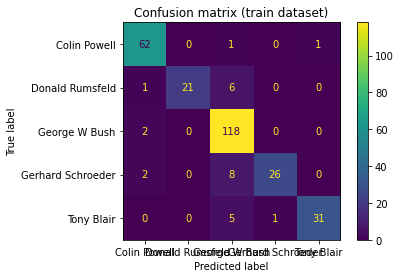

In [133]:
# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(y, ypred2rbfovo, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

## Kernel : poly && Decision_function_shape=ovo

In [134]:
X = bofs_test
y = yTest


# classif = svm.SVC(kernel='linear')
classif = svm.SVC(kernel='poly', decision_function_shape='ovo')
classif.fit(X, y)

#print(Xtest.shape)

ypred2polyovo = classif.predict(X)

#print("prediction class for [2,2]", classif.predict([[2., 2.]])
#print("support vectors: ", classif.support_vectors_)

In [135]:
polyovo = f1_score(y, ypred2polyovo, average = 'micro')
print("train F1 score = ", polyovo)
print("train accuracy score = ", accuracy_score(y, ypred2polyovo))

train F1 score =  0.9789473684210527
train accuracy score =  0.9789473684210527


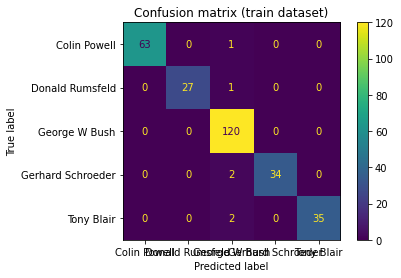

In [136]:
# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(y, ypred2polyovo, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

## Résultat

In [137]:
print(linearovr)
print(rbfovr)
print(polyovr)
print(linearovo)
print(rbfovo)
print(polyovo)

0.9859649122807017
0.9052631578947369
0.9789473684210527
0.9859649122807017
0.9052631578947369
0.9789473684210527
